In [2]:
import os
import numpy as np
from numpy.linalg import norm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalMaxPool2D
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors
import pickle as pkl
from PIL import Image
import matplotlib.pyplot as plt



In [3]:
# Charger les caractéristiques des images et les noms des fichiers
Image_features = pkl.load(open('Images_features.pkl', 'rb'))
filenames = pkl.load(open('filenames.pkl', 'rb'))

# Fonction pour extraire les caractéristiques d'une image
def extract_features_from_images(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expand_dim = np.expand_dims(img_array, axis=0)
    img_preprocess = preprocess_input(img_expand_dim)
    result = model.predict(img_preprocess).flatten()
    norm_result = result / norm(result)
    return norm_result

# Charger le modèle ResNet50

In [4]:

model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.trainable = False

model = tf.keras.models.Sequential([model,
                                   GlobalMaxPool2D()
                                   ])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [5]:
neighbors = NearestNeighbors(n_neighbors=7, algorithm='brute', metric='euclidean')

In [6]:
# Initialiser Nearest Neighbors
neighbors.fit(Image_features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=7)

1/1 [==============================] - 0s 215ms/step


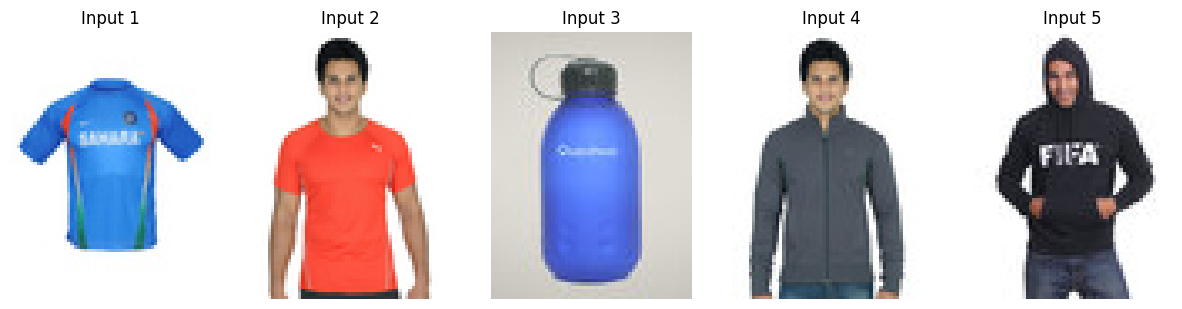

Images recommandées :


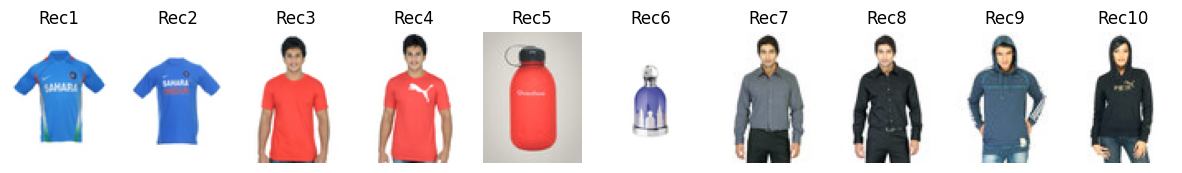

In [7]:
# Définir le dossier d'entrée
input_image_folder = "../dataset/purchase_history"

if os.path.exists(input_image_folder) and os.path.isdir(input_image_folder):
    # Récupérer toutes les images
    input_image_paths = [os.path.join(input_image_folder, file) 
                         for file in os.listdir(input_image_folder) 
                         if file.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not input_image_paths:
        print("Aucune image trouvée dans le dossier.")
    else:
        # Initialiser les listes pour stocker les recommandations
        recommended_images = []

        # Extraire les recommandations pour chaque image
        for img_path in input_image_paths:
            input_feature = extract_features_from_images(img_path, model)
            distances, indices = neighbors.kneighbors([input_feature])

            # Stocker les recommandations pour chaque image d'entrée
            recommended_images.extend(filenames[idx] for idx in indices[0][1:3])  # 2 recommandations par image

        # Affichage combiné
        total_input_images = len(input_image_paths)
        total_recommended_images = len(recommended_images)
        fig, axes = plt.subplots(1, len(input_image_paths), figsize=(15, 5))
        for i, img_path in enumerate(input_image_paths):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Input {i+1}")
        plt.show()
               # Afficher les images recommandées
        print("Images recommandées :")
        fig, axes = plt.subplots(1, len(recommended_images), figsize=(15, 5))
        for i, img_path in enumerate(recommended_images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Rec{i+1}")
        plt.show()
else:
    print("Le dossier spécifié n'existe pas ou n'est pas valide.")
